# Starbucks Capstone Project

### Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some customers might not receive any offer during certain weeks. 

My task is to combine transaction, demographic and offer data to build a model that is able to predict whether a customer is going to respond to an offer or not. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

There is transactional data showing customer purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

With all this taken into account I will follow these steps to build a model with a reasonable accuracy:
    1. Explore the datasets to gain a general understanding of the data.
    2. Clean the datasets to remove any unnecessary information and for them to be fit as training data for the model.
    3. Combine the clean datasets for the model.
    4. Build and compare different models with different classifiers to look for the one that works the best in this case.

### Metrics

To evaluate the model I will use the following metrics:

* **Accuracy:** ratio of correct predictions to the total number of samples. Accuracy is a good measure when the target variable classes in the data are nearly balanced. In this case the target variable is 'offer_completed' which can only have a binary value, and even if it is not 50/50 between 1 and 0, it is balanced.
* **Precision:** measures the proportion of offers that the model predicts will be completed and how many of those predictions were correct. TruePositives/(TruePositives+FalsePositives)
* **Recall:** measures the proportion of offers that the model predicts will be completed and how many offers the model missed. TruePositives/(TruePositives+FalseNegatives)
* **F1 score:** this metric is a weighted harmonic mean of precision and recall.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Exploring the data

In [128]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, tree
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


We have 10 offers: 4 BOGO, 4 discount and 2 informational.

In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
profile.shape

(17000, 5)

It looks like we have 17000 customers.

<Container object of 3 artists>

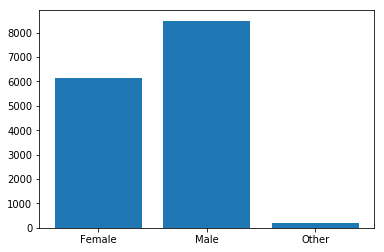

In [5]:
df_gender = profile[['gender', 'id']].groupby('gender').count()
gender_count = [x[0] for x in df_gender.values.tolist()]
genders = ['Female', 'Male', 'Other']
plt.bar(genders, gender_count)

In [6]:
gender_percentage = [(x*100)/profile.dropna(axis=0, subset=['gender']).shape[0] for x in gender_count]
gender_percentage

[41.342327150084316, 57.227655986509276, 1.430016863406408]

In this plot we can see that the majority of the customers are male.

In [7]:
profile['age'].unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [8]:
profile.loc[profile['age'] == 118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

I have noticed that some customers have registered with an age of 118, that is most likely fake so I will not take them into account when calculating the mean age and the standard deviation of the age.

In [9]:
index = profile[profile['age'] == 118].index
df_no_118 = profile.drop(index)
df_no_118['age'].mean(), df_no_118['age'].std()

(54.393524451939292, 17.38370536585499)

The mean age of the customers is 54 and the standard deviation of the customers' age is 17, so most of the customers are between the range of 37 and 71 of age.

Text(0,0.5,'Customers')

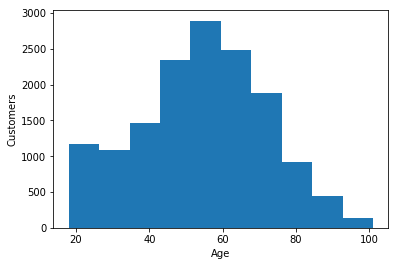

In [10]:
plt.hist(df_no_118['age'])
plt.xlabel('Age')
plt.ylabel('Customers')

Lastly for this dataset, I'm going to do the same calculations with the income column.

In [11]:
profile['income'].count()

14825

We can see that there are some nans in this column because we know there are 17000 customers, but the count of values returned 14825. I also noticed there were some nans in the gender column when calculating the percentages.

In [12]:
profile['gender'].count()

14825

In [13]:
profile.dropna(axis=0, subset=['gender'])['income'].count()

14825

As I thought, it seems like the customers that didn't register their gender also did not register their income. I will not take these customers into account when calculating the mean and the standard deviation of the income.

In [14]:
df_no_nan = profile.dropna(axis=0)
df_no_nan['income'].mean(), df_no_nan['income'].std()

(65404.991568296799, 21598.299410229494)

The mean income of the customers is 65404 and the standard deviation of the customers' income is 21598, so most of the customers have an income between the range of 43806 and 87002.

Text(0,0.5,'Customers')

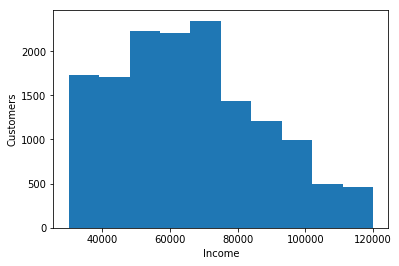

In [15]:
plt.hist(df_no_nan['income'])
plt.xlabel('Income')
plt.ylabel('Customers')

In [16]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
transcript.shape

(306534, 4)

In [19]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

It seems that this dataset has a record of every interaction between a customer and an offer.

# Cleaning the data

Now that I have a general understanding of the data, I will clean the data and combine the three datasets to build the model.

In [20]:
portfolio_clean = portfolio.drop(['channels'], axis=1)
portfolio_clean = pd.concat([portfolio_clean, pd.get_dummies(portfolio_clean['offer_type'])], axis=1)
portfolio_clean.drop(['offer_type'], axis=1, inplace=True)
portfolio_clean.head()

,difficulty,duration,id,reward,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0


For the offer data I dropped the channels column and trnasformed the offer_tytpe column into dummy variables.

In [21]:
profile_clean = profile.drop(['became_member_on'], axis=1)
profile_clean = pd.concat([profile_clean, pd.get_dummies(profile_clean['gender'])], axis=1)
profile_clean.drop(['gender'], axis=1, inplace=True)
profile_clean.head()

,age,id,income,F,M,O
0,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
2,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
4,118,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0


For the customers' demographic data I dropped the became_member_on column and transformed the gender column into dummy variables.

In [87]:
transcript_clean = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript_clean.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


I noticed that the value column in the transcript dataset is a dict that can have different keys depending of the event:
    1. 'offer received': dict only has the key 'offer id'.
    2. 'offer viewed': dict only has the key 'offer id'.
    3. 'transaction': dict only has the key 'amount'.
    4. 'offer completed': dict has the keys 'offer_id' and 'reward'.

Since what I want to predict is if a customer is going to respond to an offer or not, I'm not going to need the 'transaction' events.

In [88]:
index = transcript_clean[transcript_clean['event'] == 'transaction'].index
transcript_clean = transcript_clean.drop(index)
transcript_clean.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


Now I will combine the columns offer id and offer_id since one is null when the other is not. After that I will drop the columns I don't need anymore.

In [89]:
transcript_clean['offer_id'] = transcript_clean['offer_id'].fillna(transcript_clean['offer id'])
transcript_clean = transcript_clean.drop(['time', 'value', 'offer id', 'amount', 'reward'], axis=1)
transcript_clean.head()

,event,person,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0


Next I will transform the event column into dummy variables.

In [90]:
transcript_clean = pd.concat([transcript_clean, pd.get_dummies(transcript_clean['event'])], axis=1)
transcript_clean = transcript_clean.drop(['event'], axis=1)
transcript_clean.head()

,person,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


I would like to have in one row all the information to know if a customer, that has viewed an offer, has completed the offer or not. To accomplish this I will take these steps:
    1. Get all the rows that shows if an offer was viewed by a customer.
    2. Drop the duplicates.
    3. Iterate through the rows to calculate whether that offer was completed by the customer.
    4. Store this information in the offer completed column.

1. Get all the rows that shows if an offer was viewed by a customer.

In [91]:
transcript_test = transcript_clean[transcript_clean['offer viewed'] == 1]
transcript_test.head()

,person,offer_id,offer completed,offer received,offer viewed
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0,1
12651,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,0,0,1
12652,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,1
12653,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1
12655,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0,0,1


2. Drop the duplicates

In [92]:
transcript_test = transcript_test.drop_duplicates()
transcript_test.shape

(49135, 5)

3. Iterate through the rows to calculate whether that offer was completed by the customer.

In [93]:
def is_completed(person, offer_id):
    conditions = (transcript_clean['person'] == person) & (transcript_clean['offer_id'] == offer_id)
    if transcript_clean[conditions]['offer completed'].sum() > 0:
        return 1
    return 0

In [80]:
test = transcript_test.apply(lambda row: is_completed(row['person'], row['offer_id']), axis=1)
test

12650     1
12651     0
12652     1
12653     0
12655     0
12656     1
12660     1
12661     0
12662     0
12663     1
12664     0
12665     1
12666     1
12667     0
12668     0
12669     1
12673     0
12674     1
12675     1
12676     0
12677     1
12680     0
12681     1
12682     0
12683     0
12684     0
12685     0
12688     1
12689     0
12690     1
         ..
305620    1
305633    1
305681    0
305685    1
305798    1
305830    0
305832    0
305847    0
305853    1
305858    0
305930    0
305967    0
305987    1
306000    0
306019    0
306178    1
306188    0
306218    1
306241    0
306258    1
306314    0
306392    1
306419    0
306421    0
306433    0
306441    0
306450    0
306483    0
306490    0
306507    0
Length: 49135, dtype: int64

4. Store this information in the offer completed column.

In [95]:
transcript_test['offer completed'] = test
transcript_test.head()

,person,offer_id,offer completed,offer received,offer viewed
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0,1
12651,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,0,0,1
12652,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,1
12653,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1
12655,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0,0,1


In [96]:
transcript_clean = transcript_test.drop(['offer received', 'offer viewed'], axis=1)
transcript_clean.head()

,person,offer_id,offer completed
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1
12651,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,0
12652,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,1
12653,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0
12655,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0


Lastly, I will combine the three datasets.

In [100]:
df = pd.merge(transcript_clean, profile_clean, left_on='person', right_on='id')
df = pd.merge(df, portfolio_clean, left_on='offer_id', right_on='id')
df = df.drop(['id_x', 'id_y'], axis=1)
df.head()

,person,offer_id,offer completed,age,income,F,M,O,difficulty,duration,reward,bogo,discount,informational
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,65,53000.0,0,1,0,5,5,5,1,0,0
1,be8a5d1981a2458d90b255ddc7e0d174,f19421c1d4aa40978ebb69ca19b0e20d,1,39,51000.0,0,1,0,5,5,5,1,0,0
2,262ad0fb526a4d53b572007da60cce24,f19421c1d4aa40978ebb69ca19b0e20d,0,40,53000.0,0,1,0,5,5,5,1,0,0
3,182e68952b474700b171e21b85c258ac,f19421c1d4aa40978ebb69ca19b0e20d,0,118,NaN,0,0,0,5,5,5,1,0,0
4,f8aedd0cbea0419c806842b4265b82e5,f19421c1d4aa40978ebb69ca19b0e20d,1,72,72000.0,1,0,0,5,5,5,1,0,0


I forgot there were still some nans that I can't have to build model, so I will just drop them.

In [112]:
df = df.dropna()
df.shape

(42493, 14)

# Building the model

To build the model I will try out various classifiers such as Decision Tree, SVM and Random Forest and choose which one works the best for my case.

In [113]:
X = df[['age', 'income', 'F', 'M', 'O', 'difficulty', 'duration', 'reward', 'bogo', 'discount', 'informational']]
y = df['offer completed']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [129]:
Tree_model = tree.DecisionTreeClassifier()
Tree_model.fit(X_train, y_train)
y_pred = Tree_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.68266854924108722

The accuracy of the Decision Tree classifier is 68.2% which is not bad, but let's see how the other classifiers perform.

In [130]:
SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train)
y_pred = SVM_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.74773502765031186

The accuracy of the SVM classifier is 74.7%, even better than that of Decision Tree.

In [131]:
RFC_model = RandomForestClassifier()
RFC_model.fit(X_train, y_train)
y_pred = RFC_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.70620072949758794

The accuracy of the Random Forest classifier is 70.6%, not bad but SVM is better.

So far I have tested these three models using the default parameters, now I'm going to test them again but using GridSearchCV to look for the best parameters.

In [156]:
Tree_pipeline = Pipeline([
    ('clf', tree.DecisionTreeClassifier())
])

Tree_parameters = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 2, 4, 6, 8, 10]
}

Tree_cv = GridSearchCV(Tree_pipeline, Tree_parameters, n_jobs=4)
Tree_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': [None, 2, 4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [158]:
Tree_cv.best_params_

{'clf__criterion': 'gini', 'clf__max_depth': 6}

In [159]:
y_pred = Tree_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.77515001764913516

In [161]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.61      0.71      3768
          1       0.75      0.91      0.82      4731

avg / total       0.79      0.78      0.77      8499



We can see that using GridSearchCV to look for the best parameters improves the model a lot. Next, we are going to do the same for SVM and Random Forest to see which one is the best model for my case.

In [ ]:
SVM_pipeline = Pipeline([
    ('clf', svm.SVC())
])

SVM_parameters = {
    'clf__C': [1, 10, 100],
    'clf__gamma': [0.1, 0.01, 0.001],
    'clf__kernel': ['rbf']
}

SVM_cv = GridSearchCV(SVM_pipeline, SVM_parameters, n_jobs=4)
SVM_cv.fit(X_train, y_train)

In [165]:
SVM_cv.best_params_

{'clf__C': 100, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}

In [167]:
y_pred = SVM_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.76679609365807744

In [168]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.58      0.69      3768
          1       0.73      0.91      0.81      4731

avg / total       0.78      0.77      0.76      8499



In [173]:
RFC_pipeline = Pipeline([
    ('clf', RandomForestClassifier())
])

RFC_parameters = {
    'clf__n_estimators': [10, 20, 50, 100],
    'clf__max_depth': [None, 2, 4, 6, 8, 10],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 5]
}

RFC_cv = GridSearchCV(RFC_pipeline, RFC_parameters, n_jobs=4)
RFC_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'clf__n_estimators': [10, 20, 50, 100], 'clf__max_depth': [None, 2, 4, 6, 8, 10], 'clf__min_samples_split': [2, 5, 10], 'clf__min_samples_leaf': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [174]:
RFC_cv.best_params_

{'clf__max_depth': 8,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__n_estimators': 10}

In [175]:
y_pred = RFC_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.77585598305683023

In [176]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.85      0.60      0.70      3768
          1       0.74      0.92      0.82      4731

avg / total       0.79      0.78      0.77      8499



It seems that, with the right parameters, the Random Forest classifier is the best classifier for this case, with an accuracy of 77.5%. Although we can see that the Decision Tree classifier returns almost the same classification report, they are not too far apart.

# Results

For this project, I chose to create a model that is able to predict whether a customer is going to complete an offer or not.
All the three models I have built meet this requirement with a satisfactory accuracy:

* Decision Tree: 77.51% accuracy.
* SVM: 76.67% accuracy.
* Random Forest: 77.58% accuracy.

At first these models did not have that much accuracy since I used the default parameters of the classifiers.
After looking for the parameters of each classifier that work best in my case, using GridSearchCV, the models accuracy improved a lot and finally, I decided to choose the model that uses Random Forest classifier since its accuracy is the highest even if by a tiny margin.

So the final answer to this project is a model built with Random Forest classifier and the following parameters:

* max_depth: 8
* min_samples_leaf: 1
* min_samples_split: 2
* n_estimators: 10

# Conclusion

This project starts with three datasets that contain transaction, customer demographic and offer data. Once again, I chose to use this data to build a model able to predict if a customer is going to complete an offer or not.

To evaluate this model I mostly looked at the accuracy metric (the reason is stated below), but here is a rundown of the metrics you can see in the outputs of the model tests:

* **Accuracy:** ratio of correct predictions to the total number of samples. Accuracy is a good measure when the target variable classes in the data are nearly balanced. In this case the target variable is 'offer_completed' which can only have a binary value, and even if it is not 50/50 between 1 and 0, it is balanced.
* **Precision:** measures the proportion of offers that the model predicts will be completed and how many of those predictions were correct. TruePositives/(TruePositives+FalsePositives)
* **Recall:** measures the proportion of offers that the model predicts will be completed and how many offers the model missed. TruePositives/(TruePositives+FalseNegatives)
* **F1 score:** this metric is a weighted harmonic mean of precision and recall.

To accomplish this task I followed this general steps:

* First I explored the datasets analytics just to gain a general understanding of the data structure.
* Next I cleaned the data to remove unnecesary data that is not relevant, or not too relevant at least, to predict offer completion.
* Before starting with the implementation of the model I combined the three datasets provided after cleaning them.
* Last thing I did is to build different models with different classifiers and evaluate them to choose the one that works best for my case.

Particularly, I think the most interesting and important parts of this project where cleaning the data and hyperparameter tuning the classifiers.

Cleaning the data was difficult since I had to think about if the data of each column was actually important to build my model. After removing all the data I thought was not necessary, I had to process the data to get a dataset fit to be used to train the model. The most important step I did here was selecting only the data of when a user, that has viewed an offer, has completed the offer or not.

About hyperparameter tuning, I found that it is very important even if it takes a lot of time to run, since choosing the best parameters for each classifiers improves the model a lot. This step wasn't that hard, at least not as hard as waiting for the execution of the grid search to finish.

After all, I concluded that the best model for my case is the one that uses Random Forest classifier with the following parameters:

* max_depth: 8
* min_samples_leaf: 1
* min_samples_split: 2
* n_estimators: 10

This model has an accuracy of 77.58%.

# Possible Improvements

I think that if I had data of more products, since this dataset is a simplified version of the real Starbucks app, I could build a better model as well as be able to predict the completion of way more offers.

Also, another way to possibly improve the model is to try out more classifiers such as Naive Bayes, K Means Clustering, Support Vector Machine and so on.